<center>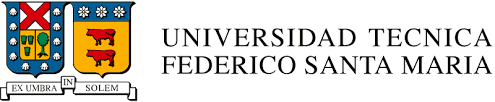</center>




<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477/577 Redes Neuronales Artificiales - 2022-2 </h1>

<H3 align='center'> Tarea 2: Grape disease detection  </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Carga de datos y preprocesamientos
* Convoluciones y parámetros
* Profundidad
* Image Data Augmentation
* Bloque Residual
* Bloque Inception
* Transfer Learning

<hr style="height:2px;border:none"/>


## 1 - Redes Convolucionales para la detección de enfermedades en la uva.

### Información y anexos

En esta oportunidad se trabajará con un conjunto de imágenes de hojas de las plantas de uva y la tarea será identificar cuál de las 3 enfermedades esta presente en la plante o si esta sana, a partir de las imágenes entregadas. A continuación se presentan 4 sitios en para encontrar más información acerca de las enfermedades de las uvas, de las cuales se trabajará con las últimas 3 listadas:

- [Diseases of Grape (Vitis spp.)](https://web.archive.org/web/20080223134516/http://www.apsnet.org/online/common/names/grape.asp)

- [Black rot](http://ipm.illinois.edu/diseases/series700/rpd703/)

- [Black Measles](https://ieeexplore.ieee.org/document/9397205)

- [Isariopsis leaf spot](http://horticulturejournal.usamv.ro/pdf/2017/Art33.pdf)



## Python libraries

In [1]:
import zipfile as zf
import matplotlib.pyplot as plt
import numpy as np
import filecmp as fcmp
import os
import scipy as sp
from PIL import Image
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Input, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import AveragePooling2D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import gradient_descent_v2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.utils import np_utils
from keras.callbacks import History, EarlyStopping

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit

## 1.a Carga de datos y visualizaciones

Establezca la ubicación de los datos.

In [2]:
data_dir = 'C:/Users/benja/Documents/git/Redes neuronales/Tarea 2'
data_zip_path = data_dir + '/Enunciado Tarea 2.zip'

Descomprima los datos.

In [3]:
#with zf.ZipFile(data_zip_path, 'r') as zip_ref:
#    zip_ref.extractall(data_dir)
data_dir_Grapes = data_dir+ '/Grape'

Revise las imágenes de cada carpeta y cargue las imágenes en un arreglo $X$, el nombre de la carpeta indica el nombre de cada clase $y$. Cargue los nombres de las clases en un arreglo de tal forma que cada imagen $X$ esté asociada a su respectiva clase $y$.

In [4]:
X = list()
y = list()

for dirname, _, filenames in os.walk(data_dir_Grapes):           
    for filename in filenames: 
        image = Image.open(os.path.join(dirname, filename))
        X.append(np.array(image, dtype=np.uint8))
        y.append(np.array(os.path.split(dirname)[1]))   
X = np.asarray(X)
y = np.asarray(y)

### ¿Qué porcentaje del total de imagenes tiene cada clase? ¿Están balanceadas las clases?

In [20]:
print('Per class count:')
for cls, n in zip(*np.unique(y, return_counts=True)):
    print(f'{cls}: {n} ({(n/float(len(y)))*100:.2f}%)')

Per class count:
Grape___Black_rot: 1180 (29.05%)
Grape___Esca_(Black_Measles): 1383 (34.05%)
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1076 (26.49%)
Grape___healthy: 423 (10.41%)


### Visualice algunas imágenes de cada una de las clases junto con sus nombres y revise sus dimensiones y tipo de dato.

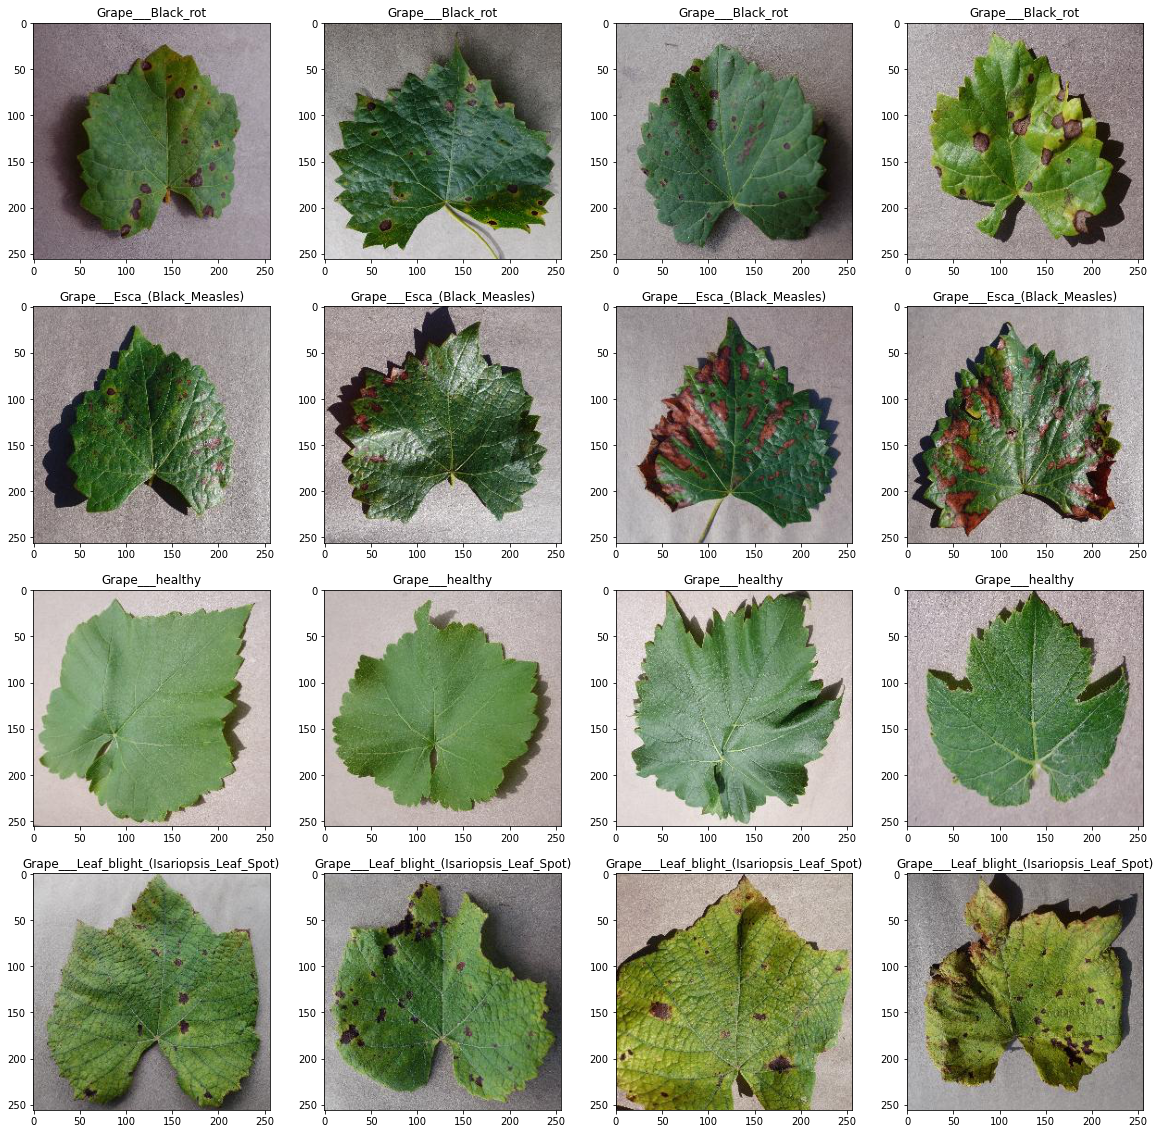

In [62]:
plt.rcParams["figure.figsize"]=[20,20]
plt.subplot(4, 4, 1)
plt.title(y[0])
plt.imshow(Image.fromarray(X[0]))
plt.subplot(4, 4, 2)
plt.title(y[1])
plt.imshow(Image.fromarray(X[1]))
plt.subplot(4, 4, 3)
plt.title(y[3])
plt.imshow(Image.fromarray(X[3]))
plt.subplot(4, 4, 4)
plt.title(y[4])
plt.imshow(Image.fromarray(X[4]))

plt.subplot(4, 4, 5)
plt.title(y[1181])
plt.imshow(Image.fromarray(X[1181]))
plt.subplot(4, 4, 6)
plt.title(y[1182])
plt.imshow(Image.fromarray(X[1182]))
plt.subplot(4, 4, 7)
plt.title(y[1183])
plt.imshow(Image.fromarray(X[1183]))
plt.subplot(4, 4, 8)
plt.title(y[1184])
plt.imshow(Image.fromarray(X[1184]))

plt.subplot(4, 4, 9)
plt.title(y[2563])
plt.imshow(Image.fromarray(X[2563]))
plt.subplot(4, 4, 10)
plt.title(y[2564])
plt.imshow(Image.fromarray(X[2564]))
plt.subplot(4, 4, 11)
plt.title(y[2565])
plt.imshow(Image.fromarray(X[2565]))
plt.subplot(4, 4, 12)
plt.title(y[2566])
plt.imshow(Image.fromarray(X[2566]))

plt.subplot(4, 4, 13)
plt.title(y[3639])
plt.imshow(Image.fromarray(X[3639]))
plt.subplot(4, 4, 14)
plt.title(y[3640])
plt.imshow(Image.fromarray(X[3640]))
plt.subplot(4, 4, 15)
plt.title(y[3641])
plt.imshow(Image.fromarray(X[3641]))
plt.subplot(4, 4, 16)
plt.title(y[3642])
plt.imshow(Image.fromarray(X[3642]))
plt.show()

#### Revisemos entonces sus dimensiones y el tipo de dato

## 1.b Preprocesamiento

Transforme $y$ a encoding one hot vector, para esto utilice la librería de SciKit Learn. OneHotEncoder recibe valores categóricos numéricos, por lo que las clases en formato string deben ser transformados vía Label Encoding antes de aplicar One Hot Encoding.

### Label Encoding

In [5]:
# Creating instance of labelencoder
le = LabelEncoder()

# Fit the transformer
le.fit(y)
y_le = le.transform(y)

### OneHotEncoding

In [6]:
# Creating instance of onehotencoder
ohe = OneHotEncoder(handle_unknown='ignore')

# Fit the transformer
ohe.fit(y_le.reshape(-1,1))
y_ohe = (ohe.transform(y_le.reshape(-1,1))).toarray()


### Conjuntos de datos
Separe los datos en conjuntos de entrenamiento, validación y prueba. Elija un porcentaje para separar los conjuntos y justifique.

In [7]:
sf = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, val_index in sf.split(X, y_ohe):
    X_train, X_test = X[train_index], X[val_index]
    y_train, y_test = y_ohe[train_index], y_ohe[val_index]  

In [8]:
sf2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sf2.split(X_train, y_train):
    X_train, X_val = X_train[train_index], X_train[test_index]
    y_train, y_val = y_train[train_index], y_train[test_index]  

Estos porcentajes se justifican de lo estudiado en la tarea 1, queremos un split de validación lo suficientemente grande pero que no acapare toda la data

### Normalización de los datos

Por ahora los valores de los píxeles de las imágenes se encuentran en el rango $[0,255]$. Normalice cada canal RGB por separado y obtenga $\langle(\mu_R,\sigma^2_R), (\mu_G,\sigma^2_G), (\mu_B,\sigma^2_B)\rangle_\text{Train Set}$ y luego use estos parámetros para normalizar los 3 conjuntos separados en la preguna anterior.

In [9]:
# Perform Standarization
def prep_normalize(X_train, X_val, X_test):	
		
		x_means = X_train.mean(axis=(0,1,2), keepdims=True)
		x_std = X_train.std(axis=(0,1,2), keepdims=True)
		
		X_train	= ((X_train - x_means) / x_std).astype(np.float32)
		X_val   = ((X_val - x_means) / x_std).astype(np.float32)
		X_test  = ((X_test - x_means) / x_std).astype(np.float32)

		# Standarize each channel separately.
		return X_train, X_val, X_test

In [10]:
X_train, X_val, X_test = prep_normalize(X_train, X_val, X_test)

## 1.c Primera Red Convolucional

Entrenaremos una primera red convolucional sobre los datos, con la mayoría de los parámetros por defecto. Cree primero una red con la siguiente la estructura $C \times P \times C \times P \times D\times D$, donde $C$ representa una capa convolucional, $P$ una capa Max Pooling y $D$ una capa densa. Note que antes de la capa densa debe agregar una capa Flatten que transforma los filtros a vectores que luego pueden ser utilizados por la capa densa.

Para los parámetros de las capas, fijaremos ambas capas convolucionales con 128 filtros de $3 \times 3$, stride por default de $1 \times 1$, y padding "same", es decir, agregaremos $0$ a los bordes de la imágen de tal manera que se preserve la dimension de la imágen al atravesar la capa, las capas de pooling tendrán tamaño y stride $2\times 2$, como muentra el código. 

Utilice el método `.summary` del modelo para ver la cantidad de parámetros y las dimensiones de los outputs de cada capa. Justifique el número de parámetros y el Output Shape de cada capa en función de la estructura de la red y lo aprendido en clase.

Preguntas:

Investigue y explique qué es el stride en la capa convolucional, ¿Qué operación efectúa la activación SoftMax y qué representaría en términos del problema el vector de salida de la red?

* En la capa convolucional, el kernel se desplaza un pixel hacia la derecha, o hacia abajo, durante cada iteración. Cada uno de estos desplazamientos se conoce como stride (o salto).
* La activación SoftMax realiza una "compresión" de output llevando un vector de valores reales a un dominio en el rango de 0 a 1, esto permite abordar problemas de clasificación binaria y multiclase, donde el vector de salida correspoden a un score de clasificación si o no, en el caso multiclase se interpreta como cuán segura está la red de clasificar un input con cada clase.

In [11]:
def baseline_model(inputs,num_classes):    
    x = inputs
    # create model    
    conv1  = Conv2D(filters = 128,
                    kernel_size = (3,3),
                    strides=(1, 1),
                    padding = 'same',
                    activation = 'relu',
                    data_format="channels_last")(x)

    pool1  = MaxPooling2D(pool_size = (2,2))(conv1)

    conv2  = Conv2D(filters = 128,
                    kernel_size = (3,3),
                    strides=(1, 1),
                    padding = 'same',
                    activation = 'relu')(pool1)

    pool2  = MaxPooling2D(pool_size = (2,2))(conv2)    

    dense1 = Dense(units=32, activation='relu')(Flatten()(pool2))    

    dense2 = Dense(units=num_classes, activation='softmax')(dense1)

    model  = Model(inputs = inputs, outputs = dense2)    
    
    return model

Compile la red definida en el item anterior. Para esta pregunta puede usar la activación, el optimizador, learning rate y learning rate decay que usted desee con sus respectivos argumentos, justificando su elección, y debe usar como loss Categorical Crossentropy.

Entrene la red hasta observar convergencia recuperando su history. Grafique como varía el accuracy en entrenamiento y validación a lo largo del aprendizaje. Adicionalmente obtenga el accuracy para todo el conjunto de test.

Preguntas: ¿Por qué preferimos medir crossentropy y no por ejemplo MSE en este problema?¿Qué valor representa el accuracy?, ¿Le parece buena medida de desempeño para este problema?
* Suele ser más apropiado utilizar crossentropy en problemas de clasificación porque lidia mejor con las funciones sigmoide y softmax, y converge más rápido que el mse.
* accuracy representa una nedida ponderada de acierto de predicción del modelo, en general en accuracy se utiliza en problemas de regresión donde el output puede ser un real cualquiera, para problemas de clasificación binaria y multiclase es preferible utilizar binary o categorical accuracy respectivamente.

In [12]:
inputs = Input(shape=X_train.shape[1:])
num_classes = 4

# build the model
model = baseline_model(inputs,num_classes)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
my_callbacks = [History(), EarlyStopping(patience=10, min_delta=0.01, monitor='val_accuracy', mode="max", restore_best_weights = True)]

# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=10)

Epoch 1/5
293/293 [==============================] - 780s 3s/step - loss: 0.8731 - accuracy: 0.7377 - val_loss: 0.3225 - val_accuracy: 0.8673
Epoch 2/5
293/293 [==============================] - 748s 3s/step - loss: 0.3288 - accuracy: 0.8806 - val_loss: 0.3533 - val_accuracy: 0.8714
Epoch 3/5
293/293 [==============================] - 762s 3s/step - loss: 0.1801 - accuracy: 0.9333 - val_loss: 0.2531 - val_accuracy: 0.9001
Epoch 4/5
293/293 [==============================] - 760s 3s/step - loss: 0.1184 - accuracy: 0.9569 - val_loss: 0.7871 - val_accuracy: 0.7770
Epoch 5/5
293/293 [==============================] - 755s 3s/step - loss: 0.1727 - accuracy: 0.9449 - val_loss: 0.3619 - val_accuracy: 0.8837


In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 524288)            0     

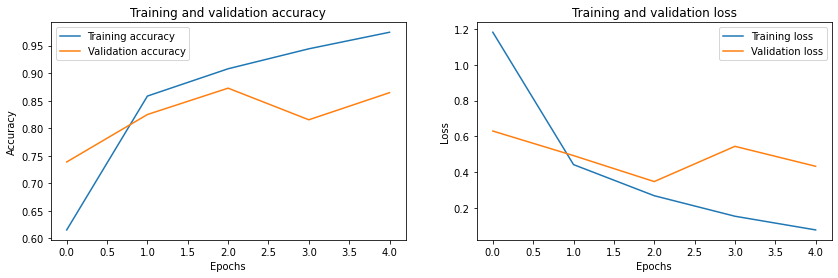

In [17]:
plt.rcParams["figure.figsize"]=[14,4]
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
# Test evaluation of the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

In [19]:
print(f'Loss in test data: {test_loss}\nAccuracy in test data: {test_acc}')

Loss in test data: 0.46168577671051025
Accuracy in test data: 0.872235894203186


## 1.d Parámetros de la capa Convolucional

Entrene la misma red (arquitectura $C\times P\times C\times P\times D\times D$) de la pregunta anterior. A continuación en cada punto debe probar las variaciones que se le indican, manteniendo el resto tal como estaba. Por ejemplo si está probando distintos números de filtros, solo se modifica el número de filtros; si está probando distintos kernel size, entonces el número de filtros volverá a fijarse en 128 como estaba en la pregunta anterior.

+ filters (pruebe 2 números, ej: 512, 32),
+ kernel_size (pruebe $1\times 1$, $5\times 5$, $7\times 7$ y $9\times 9$),
+ strides (pruebe (2,2) y (3,3))
+ padding (pruebe valid),
+ dilation_rate (pruebe 1,2,3)
+ MaxPooling y AveragePooling (en ambos casos pruebe stride de (3,3), (5,5))
+ Dense (pruebe con 2 capas densas con 2 números de neuronas distintos en cada capa (sin contar la de salida softmax de 4 clases), por ejemplo: 
$$\cdots \times D(units=64)\times D(units=32)\times D(\text{num_clases}, ``softmax"),$$
$$\cdots \times D(units=128)\times D(units=8)\times D(\text{num_clases}, ``softmax"),$$
$$\cdots \times D(units=256)\times D(\text{num_clases}, ``softmax"),$$
$$\cdots \times D(units=16)\times D(\text{num_clases}, ``softmax").$$

Lea la documentación de esta herramienta e investigue cuales de estos parámetros se pueden combinar para realizar una búsqueda en grilla (¿Qué es una búsqueda en grilla?) y cuales no son compatibles entre ellos para ciertos valores, explique por qué.

Formule la dimensión de salida $(H_{out}, W_{out})$ en función de la dimensión de entrada $(H_{in}, W_{in})$, el tamaño del kernel $k$, el stride $s$, el padding $p$ y el dilation_rate $d$.

 

In [12]:
def p_model(params):
    x = params[0]
    conv1 = Conv2D(filters = params[2],
                   kernel_size = params[3],
                   strides = params[4],
                   padding = params[5],
                   dilation_rate = params[6],
                   activation = 'relu',
                   data_format = "channels_last")(x)

    pool1  = params[7](conv1)

    conv2  = Conv2D(filters = params[2],
                    kernel_size = params[3],
                    strides = params[4],
                    padding = params[5],
                    dilation_rate = params[6],
                    activation = 'relu')(pool1)

    pool2  = params[7](conv2)    

    dense_I = params[9](Flatten()(pool2))
    
    if params[8] == 'no':
        dense_II = dense_I
    else:
        dense_II = params[10](dense_I)  
    
    dense_O = Dense(units=num_classes, activation='softmax')(dense_II)

    model  = Model(inputs = inputs, outputs = dense_O)  

    return model

### Primero probemos con dos filters diferentes (200 y 32).

In [13]:
inputs = Input(shape=X_train.shape[1:])
num_classes = 4

In [20]:
params = [
    [inputs, num_classes, 200, (3,3), (1,1), 'same', (1,1),MaxPooling2D(pool_size = (2,2)),'no', Dense(units=32, activation='relu'),Dense(units=32, activation='relu')], 
    [inputs, num_classes, 32, (3,3), (1,1), 'same', (1,1),MaxPooling2D(pool_size = (2,2)),'no', Dense(units=32, activation='relu'),Dense(units=32, activation='relu')]
]

i = 0
while i < len(params):

    # build the model
    model = p_model(params[i])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    my_callbacks = [History(), EarlyStopping(patience=10, min_delta=0.01, monitor='val_accuracy', mode="max", restore_best_weights = True)]

    # Fit the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=10)
    
    i+=1

Epoch 1/5
293/293 [==============================] - 1369s 5s/step - loss: 1.2382 - accuracy: 0.5975 - val_loss: 0.7117 - val_accuracy: 0.7018
Epoch 2/5
293/293 [==============================] - 1355s 5s/step - loss: 0.5144 - accuracy: 0.7893 - val_loss: 0.6012 - val_accuracy: 0.7510
Epoch 3/5
293/293 [==============================] - 1360s 5s/step - loss: 0.3544 - accuracy: 0.8711 - val_loss: 0.4660 - val_accuracy: 0.8153
Epoch 4/5
293/293 [==============================] - 1360s 5s/step - loss: 0.2244 - accuracy: 0.9313 - val_loss: 0.4164 - val_accuracy: 0.8509
Epoch 5/5
293/293 [==============================] - 1357s 5s/step - loss: 0.1500 - accuracy: 0.9576 - val_loss: 0.4957 - val_accuracy: 0.8468
Epoch 1/5
293/293 [==============================] - 135s 459ms/step - loss: 0.8420 - accuracy: 0.7500 - val_loss: 0.4141 - val_accuracy: 0.8509
Epoch 2/5
293/293 [==============================] - 133s 454ms/step - loss: 0.1919 - accuracy: 0.9360 - val_loss: 0.3284 - val_accuracy: 0.

### Probemos ahora cambiando el kernel_size (probaremos $1 \times 1, 5 \times 5, 7 \times 7$ y $9 \times 9$ )

In [29]:
params = [[inputs, num_classes, 128, (1,1), (1,1), 'same', (1,1),MaxPooling2D(pool_size = (2,2)),'no', Dense(units=32, activation='relu'),Dense(units=32, activation='relu')],
    [inputs, num_classes, 128, (5,5), (1,1), 'same', (1,1),MaxPooling2D(pool_size = (2,2)),'no', Dense(units=32, activation='relu'),Dense(units=32, activation='relu')],
    [inputs, num_classes, 128, (7,7), (1,1), 'same', (1,1),MaxPooling2D(pool_size = (2,2)),'no', Dense(units=32, activation='relu'),Dense(units=32, activation='relu')],
    [inputs, num_classes, 128, (9,9), (1,1), 'same', (1,1),MaxPooling2D(pool_size = (2,2)),'no', Dense(units=32, activation='relu'),Dense(units=32, activation='relu')]
         ]

i = 0
while i < len(params):

    # build the model
    model = p_model(params[i])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    my_callbacks = [History(), EarlyStopping(patience=10, min_delta=0.01, monitor='val_accuracy', mode="max", restore_best_weights = True)]

    # Fit the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=10)
    
    i+=1

Epoch 1/5
293/293 [==============================] - 317s 1s/step - loss: 1.1238 - accuracy: 0.7695 - val_loss: 0.4738 - val_accuracy: 0.8358
Epoch 2/5
293/293 [==============================] - 314s 1s/step - loss: 0.2773 - accuracy: 0.9124 - val_loss: 0.2822 - val_accuracy: 0.9029
Epoch 3/5
293/293 [==============================] - 313s 1s/step - loss: 0.0986 - accuracy: 0.9682 - val_loss: 0.3873 - val_accuracy: 0.8947
Epoch 4/5
293/293 [==============================] - 312s 1s/step - loss: 0.0679 - accuracy: 0.9771 - val_loss: 0.3637 - val_accuracy: 0.8919
Epoch 5/5
293/293 [==============================] - 312s 1s/step - loss: 0.0292 - accuracy: 0.9894 - val_loss: 0.2824 - val_accuracy: 0.9261
Epoch 1/5
293/293 [==============================] - 1428s 5s/step - loss: 1.5036 - accuracy: 0.3376 - val_loss: 1.3227 - val_accuracy: 0.3406
Epoch 2/5
293/293 [==============================] - 1425s 5s/step - loss: 1.3174 - accuracy: 0.3403 - val_loss: 1.3138 - val_accuracy: 0.3406
Epoc

### Probemos ahora con dos strides diferentes: (2,2) y (3,3).

In [31]:
params = [[inputs, num_classes, 128, (3,3), (2,2), 'same', (1,1),MaxPooling2D(pool_size = (2,2)),'no', Dense(units=32, activation='relu'),Dense(units=32, activation='relu')],
    [inputs, num_classes, 128, (3,3), (3,3), 'same', (1,1),MaxPooling2D(pool_size = (2,2)),'no', Dense(units=32, activation='relu'),Dense(units=32, activation='relu')]
         ]

i = 0
while i < len(params):

    # build the model
    model = p_model(params[i])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    my_callbacks = [History(), EarlyStopping(patience=10, min_delta=0.01, monitor='val_accuracy', mode="max", restore_best_weights = True)]

    # Fit the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=10)
    
    i+=1

Epoch 1/5
293/293 [==============================] - 97s 330ms/step - loss: 0.5105 - accuracy: 0.7955 - val_loss: 0.2824 - val_accuracy: 0.8906
Epoch 2/5
293/293 [==============================] - 92s 315ms/step - loss: 0.2161 - accuracy: 0.9207 - val_loss: 0.1995 - val_accuracy: 0.9316
Epoch 3/5
293/293 [==============================] - 94s 322ms/step - loss: 0.1400 - accuracy: 0.9525 - val_loss: 0.1609 - val_accuracy: 0.9302
Epoch 4/5
293/293 [==============================] - 93s 316ms/step - loss: 0.1073 - accuracy: 0.9631 - val_loss: 0.1648 - val_accuracy: 0.9302
Epoch 5/5
293/293 [==============================] - 92s 315ms/step - loss: 0.0753 - accuracy: 0.9726 - val_loss: 0.1457 - val_accuracy: 0.9412
Epoch 1/5
293/293 [==============================] - 38s 127ms/step - loss: 0.6232 - accuracy: 0.7442 - val_loss: 0.3977 - val_accuracy: 0.8413
Epoch 2/5
293/293 [==============================] - 37s 127ms/step - loss: 0.2628 - accuracy: 0.9022 - val_loss: 0.3399 - val_accuracy:

### Ahora probaremos con un padding diferente (valid).

In [32]:
params = [[inputs, num_classes, 128, (3,3), (1,1), 'valid', (1,1),MaxPooling2D(pool_size = (2,2)),'no', Dense(units=32, activation='relu'),Dense(units=32, activation='relu')]]

i = 0
while i < len(params):

    # build the model
    model = p_model(params[i])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    my_callbacks = [History(), EarlyStopping(patience=10, min_delta=0.01, monitor='val_accuracy', mode="max", restore_best_weights = True)]

    # Fit the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=10)
    
    i+=1

Epoch 1/5
293/293 [==============================] - 660s 2s/step - loss: 0.8253 - accuracy: 0.7599 - val_loss: 0.3388 - val_accuracy: 0.8714
Epoch 2/5
293/293 [==============================] - 663s 2s/step - loss: 0.2860 - accuracy: 0.8950 - val_loss: 0.2827 - val_accuracy: 0.9015
Epoch 3/5
293/293 [==============================] - 662s 2s/step - loss: 0.1938 - accuracy: 0.9364 - val_loss: 0.3794 - val_accuracy: 0.8796
Epoch 4/5
293/293 [==============================] - 663s 2s/step - loss: 0.0780 - accuracy: 0.9740 - val_loss: 0.2480 - val_accuracy: 0.9166
Epoch 5/5
293/293 [==============================] - 659s 2s/step - loss: 0.1213 - accuracy: 0.9634 - val_loss: 0.3579 - val_accuracy: 0.8960


### Ahora probarmos con un dilation_rate de 1,2 y 3.

In [14]:
params = [[inputs, num_classes, 128, (3,3), (1,1), 'same', (1,1),MaxPooling2D(pool_size = (2,2)),'no', Dense(units=32, activation='relu'),Dense(units=32, activation='relu')],
    [inputs, num_classes, 128, (3,3), (1,1), 'same', (2,2),MaxPooling2D(pool_size = (2,2)),'no', Dense(units=32, activation='relu'),Dense(units=32, activation='relu')],
    [inputs, num_classes, 128, (3,3), (1,1), 'same', (3,3),MaxPooling2D(pool_size = (2,2)),'no', Dense(units=32, activation='relu'),Dense(units=32, activation='relu')]
    ]

i = 0
while i < len(params):

    # build the model
    model = p_model(params[i])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    my_callbacks = [History(), EarlyStopping(patience=10, min_delta=0.01, monitor='val_accuracy', mode="max", restore_best_weights = True)]

    # Fit the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=10)
    
    i+=1

Epoch 1/5
293/293 [==============================] - 721s 2s/step - loss: 0.9787 - accuracy: 0.6525 - val_loss: 0.5516 - val_accuracy: 0.8098
Epoch 2/5
293/293 [==============================] - 733s 3s/step - loss: 0.3876 - accuracy: 0.8570 - val_loss: 0.3596 - val_accuracy: 0.8700
Epoch 3/5
293/293 [==============================] - 749s 3s/step - loss: 0.2817 - accuracy: 0.9049 - val_loss: 0.2515 - val_accuracy: 0.8947
Epoch 4/5
293/293 [==============================] - 725s 2s/step - loss: 0.1599 - accuracy: 0.9436 - val_loss: 0.3514 - val_accuracy: 0.8769
Epoch 5/5
293/293 [==============================] - 731s 2s/step - loss: 0.1134 - accuracy: 0.9586 - val_loss: 0.2864 - val_accuracy: 0.9015
Epoch 1/5
293/293 [==============================] - 924s 3s/step - loss: 0.9653 - accuracy: 0.6744 - val_loss: 0.5994 - val_accuracy: 0.7360
Epoch 2/5
293/293 [==============================] - 919s 3s/step - loss: 0.4215 - accuracy: 0.8345 - val_loss: 0.4361 - val_accuracy: 0.8564
Epoch 

###  Ahora con MaxPooling y AveragePooling (en ambos casos probaremos stride de (3,3), (5,5)).

In [15]:
params = [[inputs, num_classes, 128, (3,3), (1,1), 'same', (1,1),MaxPooling2D(pool_size = (3,3)),'no', Dense(units=32, activation='relu'),Dense(units=32, activation='relu')],
    [inputs, num_classes, 128, (3,3), (1,1), 'same', (1,1),MaxPooling2D(pool_size = (5,5)),'no', Dense(units=32, activation='relu'),Dense(units=32, activation='relu')],
    [inputs, num_classes, 128, (3,3), (1,1), 'same', (1,1),AveragePooling2D(pool_size = (3,3)),'no', Dense(units=32, activation='relu'),Dense(units=32, activation='relu')],
    [inputs, num_classes, 128, (3,3), (1,1), 'same', (1,1),AveragePooling2D(pool_size = (5,5)),'no', Dense(units=32, activation='relu'),Dense(units=32, activation='relu')],
         ]

i = 0
while i < len(params):

    # build the model
    model = p_model(params[i])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    my_callbacks = [History(), EarlyStopping(patience=10, min_delta=0.01, monitor='val_accuracy', mode="max", restore_best_weights = True)]

    # Fit the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=10)
    
    i+=1

Epoch 1/5
293/293 [==============================] - 401s 1s/step - loss: 0.5741 - accuracy: 0.7883 - val_loss: 0.3201 - val_accuracy: 0.8906
Epoch 2/5
293/293 [==============================] - 397s 1s/step - loss: 0.2481 - accuracy: 0.9104 - val_loss: 0.3699 - val_accuracy: 0.8687
Epoch 3/5
293/293 [==============================] - 396s 1s/step - loss: 0.1583 - accuracy: 0.9395 - val_loss: 0.2706 - val_accuracy: 0.8960
Epoch 4/5
293/293 [==============================] - 401s 1s/step - loss: 0.0850 - accuracy: 0.9692 - val_loss: 0.2776 - val_accuracy: 0.9111
Epoch 5/5
293/293 [==============================] - 400s 1s/step - loss: 0.1079 - accuracy: 0.9672 - val_loss: 0.1915 - val_accuracy: 0.9302
Epoch 1/5
293/293 [==============================] - 261s 891ms/step - loss: 0.4712 - accuracy: 0.8109 - val_loss: 0.1834 - val_accuracy: 0.9152
Epoch 2/5
293/293 [==============================] - 260s 888ms/step - loss: 0.1803 - accuracy: 0.9326 - val_loss: 0.1727 - val_accuracy: 0.9261


### Dense (pruebe con 2 capas densas con 2 números de neuronas distintos en cada capa (sin contar la de salida softmax de 4 clases), por ejemplo

In [14]:
params = [[inputs, num_classes, 128, (3,3), (1,1), 'same', (1,1),MaxPooling2D(pool_size = (2,2)),'si', Dense(units=64, activation='relu'),Dense(units=32, activation='relu')],
    [inputs, num_classes, 128, (3,3), (1,1), 'same', (1,1),MaxPooling2D(pool_size = (2,2)),'si', Dense(units=128, activation='relu'),Dense(units=8, activation='relu')]
    ]

i = 0
while i < len(params):

    # build the model
    model = p_model(params[i])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    my_callbacks = [History(), EarlyStopping(patience=10, min_delta=0.01, monitor='val_accuracy', mode="max", restore_best_weights = True)]

    # Fit the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=10)
    
    i+=1

Epoch 1/5
293/293 [==============================] - 725s 2s/step - loss: 0.7617 - accuracy: 0.7538 - val_loss: 0.4257 - val_accuracy: 0.8358
Epoch 2/5
293/293 [==============================] - 711s 2s/step - loss: 0.2825 - accuracy: 0.9063 - val_loss: 0.3931 - val_accuracy: 0.8550
Epoch 3/5
293/293 [==============================] - 716s 2s/step - loss: 0.1635 - accuracy: 0.9408 - val_loss: 0.4369 - val_accuracy: 0.8605
Epoch 4/5
293/293 [==============================] - 710s 2s/step - loss: 0.1117 - accuracy: 0.9576 - val_loss: 0.4596 - val_accuracy: 0.8728
Epoch 5/5
293/293 [==============================] - 712s 2s/step - loss: 0.0928 - accuracy: 0.9682 - val_loss: 0.4553 - val_accuracy: 0.8728
Epoch 1/5
293/293 [==============================] - 761s 3s/step - loss: 1.2426 - accuracy: 0.5116 - val_loss: 1.0878 - val_accuracy: 0.5116
Epoch 2/5
293/293 [==============================] - 762s 3s/step - loss: 0.7409 - accuracy: 0.7353 - val_loss: 0.6490 - val_accuracy: 0.7620
Epoch 

## 1.e Bloque $C\times C\times P$

Cree y entrene redes utilizando *bloques* $C\times C\times P$ (dos capas convolucionales seguida de una de maxpool) y luego dos capas densas, por ejemplo la estructura de una red de 2 *bloques* sería la siguiente: $\underbrace{C\times C\times P}_{\text{bloque 1}} \times \underbrace{C\times C\times P}_{\text{bloque 2}}\times D \times D$. Puede agregar las capas densas que desee basandose en la experiencia de las preguntas anteriores o lo aprendido en clases (justifique).

La idea es explorar qué ocurre a medida que se modifica la profundidad de la red. Para esto, entrene redes con distintos números de *bloques*. Debe a lo menos entrenar una red por cada número de *bloques*: entre 1 y 5 *bloques*.

Comente sobre los dos casos extremos (1 y 5 *bloques*), ¿le parece que alguno de los dos sea buena aproximación para la clasificación de estas imágenes? Para cada red recupere history y grafique los valores de accuracy en entrenamiento y validación.

Quedan a su discreción los parámetros de cada capa convolucional, sin embargo, para el número de filtros en las capas convolucionales se recomienda disminuir el número de filtros por la mitad en cada *bloque* por ejemplo: $C(filters=128)\times C(filters=128)\times P \times C(filters=64)\times C(filters=64)\times P\times \cdots \times D \times \cdots \times D.$

In [42]:
# Red con un bloque y dos densas.

model_1 = Sequential()
model_1.add(Input(shape=(256, 256, 3)))
model_1.add(Conv2D(filters=128, kernel_size=(4, 4), activation='relu', padding='same'))
model_1.add(Conv2D(filters=128, kernel_size=(4, 4), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(4,4), strides=4, padding='valid'))
model_1.add(Flatten())
model_1.add(Dense(32, activation='relu'))
model_1.add(Dense(4, activation='softmax'))

In [43]:
model_1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 256, 256, 128)     6272      
                                                                 
 conv2d_43 (Conv2D)          (None, 256, 256, 128)     262272    
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 64, 64, 128)      0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 524288)            0         
                                                                 
 dense_18 (Dense)            (None, 32)                16777248  
                                                                 
 dense_19 (Dense)            (None, 4)                 132       
                                                     

In [44]:
# Graficos y scores del modelo_1

model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy']) 

# Fit the model

history_1 = model_1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=10)

Epoch 1/5
293/293 [==============================] - 1514s 5s/step - loss: 1.0101 - categorical_accuracy: 0.6611 - val_loss: 0.5747 - val_categorical_accuracy: 0.7606
Epoch 2/5
293/293 [==============================] - 1509s 5s/step - loss: 0.4633 - categorical_accuracy: 0.8471 - val_loss: 0.4002 - val_categorical_accuracy: 0.8618
Epoch 3/5
293/293 [==============================] - 1519s 5s/step - loss: 0.2441 - categorical_accuracy: 0.9227 - val_loss: 0.5084 - val_categorical_accuracy: 0.8673
Epoch 4/5
293/293 [==============================] - 1539s 5s/step - loss: 0.1868 - categorical_accuracy: 0.9432 - val_loss: 0.6464 - val_categorical_accuracy: 0.8427
Epoch 5/5
293/293 [==============================] - 1522s 5s/step - loss: 0.1373 - categorical_accuracy: 0.9614 - val_loss: 1.6440 - val_categorical_accuracy: 0.7428


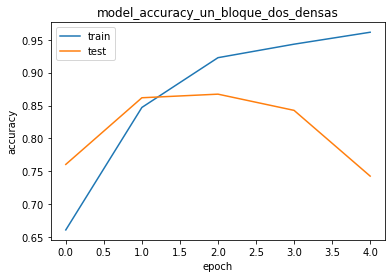

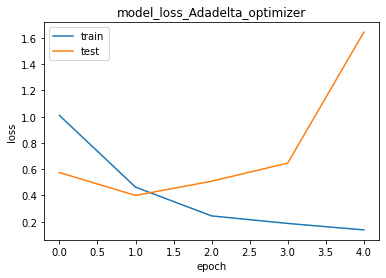

In [45]:
# Graficos

plt.plot(history_1.history['categorical_accuracy'])
plt.plot(history_1.history['val_categorical_accuracy'])
plt.title('model_accuracy_un_bloque_dos_densas')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model_loss_Adadelta_optimizer')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [46]:
# Red con dos bloque y dos densas.

model_2 = Sequential()
model_2.add(Input(shape=(256, 256, 3)))
model_2.add(Conv2D(filters=128, kernel_size=(4, 4), activation='relu', padding='same'))
model_2.add(Conv2D(filters=128, kernel_size=(4, 4), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(4,4), strides=4, padding='same'))
model_2.add(Conv2D(filters=64, kernel_size=(4, 4), activation='relu', padding='same'))
model_2.add(Conv2D(filters=64, kernel_size=(4, 4), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(4,4), strides=4, padding='valid'))
model_2.add(Flatten())
model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(4, activation='softmax'))

In [47]:
model_2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 256, 256, 128)     6272      
                                                                 
 conv2d_45 (Conv2D)          (None, 256, 256, 128)     262272    
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 64, 64, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 64, 64, 64)        131136    
                                                                 
 conv2d_47 (Conv2D)          (None, 64, 64, 64)        65600     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                

In [48]:
# Graficos y scores del modelo_2

model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy']) 

# Fit the model

history_2 = model_2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=10)

Epoch 1/5
293/293 [==============================] - 1600s 5s/step - loss: 0.6666 - categorical_accuracy: 0.7120 - val_loss: 0.3943 - val_categorical_accuracy: 0.8276
Epoch 2/5
293/293 [==============================] - 1605s 5s/step - loss: 0.2632 - categorical_accuracy: 0.8971 - val_loss: 0.4177 - val_categorical_accuracy: 0.8659
Epoch 3/5
293/293 [==============================] - 1608s 5s/step - loss: 0.1609 - categorical_accuracy: 0.9422 - val_loss: 0.1824 - val_categorical_accuracy: 0.9316
Epoch 4/5
293/293 [==============================] - 1612s 6s/step - loss: 0.0930 - categorical_accuracy: 0.9661 - val_loss: 0.2377 - val_categorical_accuracy: 0.9138
Epoch 5/5
293/293 [==============================] - 1609s 5s/step - loss: 0.1376 - categorical_accuracy: 0.9590 - val_loss: 0.1602 - val_categorical_accuracy: 0.9508


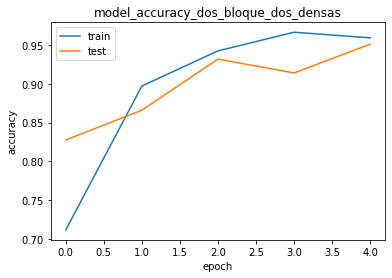

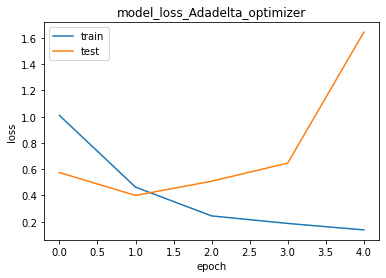

In [49]:
# Graficos

plt.plot(history_2.history['categorical_accuracy'])
plt.plot(history_2.history['val_categorical_accuracy'])
plt.title('model_accuracy_dos_bloque_dos_densas')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model_loss_Adadelta_optimizer')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [53]:
# Red con tres bloque y dos densas.

model_3 = Sequential()
model_3.add(Input(shape=(256, 256, 3)))
model_3.add(Conv2D(filters=128, kernel_size=(4, 4), activation='relu', padding='same'))
model_3.add(Conv2D(filters=128, kernel_size=(4, 4), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(4,4), strides=4, padding='same'))
model_3.add(Conv2D(filters=64, kernel_size=(4, 4), activation='relu', padding='same'))
model_3.add(Conv2D(filters=64, kernel_size=(4, 4), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(4,4), strides=4, padding='same'))
model_3.add(Conv2D(filters=32, kernel_size=(4, 4), activation='relu', padding='same'))
model_3.add(Conv2D(filters=32, kernel_size=(4, 4), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(4,4), strides=4, padding='valid'))
model_3.add(Flatten())
model_3.add(Dense(32, activation='relu'))
model_3.add(Dense(4, activation='softmax'))

In [54]:
model_3.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 256, 256, 128)     6272      
                                                                 
 conv2d_55 (Conv2D)          (None, 256, 256, 128)     262272    
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 64, 64, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 64, 64, 64)        131136    
                                                                 
 conv2d_57 (Conv2D)          (None, 64, 64, 64)        65600     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                

In [55]:
# Graficos y scores del modelo_3

model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy']) 

# Fit the model

history_3 = model_3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=10)

Epoch 1/5
293/293 [==============================] - 1627s 6s/step - loss: 0.6648 - categorical_accuracy: 0.7055 - val_loss: 0.3753 - val_categorical_accuracy: 0.8454
Epoch 2/5
293/293 [==============================] - 1624s 6s/step - loss: 0.2722 - categorical_accuracy: 0.8988 - val_loss: 0.2383 - val_categorical_accuracy: 0.9234
Epoch 3/5
293/293 [==============================] - 1603s 5s/step - loss: 0.2039 - categorical_accuracy: 0.9299 - val_loss: 0.2803 - val_categorical_accuracy: 0.9138
Epoch 4/5
293/293 [==============================] - 1603s 5s/step - loss: 0.1771 - categorical_accuracy: 0.9391 - val_loss: 0.2666 - val_categorical_accuracy: 0.9234
Epoch 5/5
293/293 [==============================] - 1596s 5s/step - loss: 0.1054 - categorical_accuracy: 0.9607 - val_loss: 0.2309 - val_categorical_accuracy: 0.9220


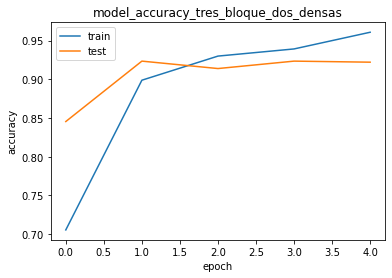

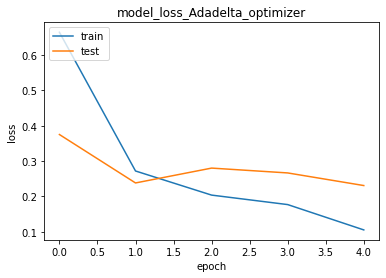

In [56]:
# Graficos

plt.plot(history_3.history['categorical_accuracy'])
plt.plot(history_3.history['val_categorical_accuracy'])
plt.title('model_accuracy_tres_bloque_dos_densas')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model_loss_Adadelta_optimizer')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [57]:
# Red con cuatro bloque y dos densas.

model_4 = Sequential()
model_4.add(Input(shape=(256, 256, 3)))
model_4.add(Conv2D(filters=128, kernel_size=(4, 4), activation='relu', padding='same'))
model_4.add(Conv2D(filters=128, kernel_size=(4, 4), activation='relu', padding='same'))
model_4.add(MaxPooling2D(pool_size=(4,4), strides=4, padding='same'))
model_4.add(Conv2D(filters=64, kernel_size=(4, 4), activation='relu', padding='same'))
model_4.add(Conv2D(filters=64, kernel_size=(4, 4), activation='relu', padding='same'))
model_4.add(MaxPooling2D(pool_size=(4,4), strides=4, padding='same'))
model_4.add(Conv2D(filters=32, kernel_size=(4, 4), activation='relu', padding='same'))
model_4.add(Conv2D(filters=32, kernel_size=(4, 4), activation='relu', padding='same'))
model_4.add(MaxPooling2D(pool_size=(4,4), strides=4, padding='same'))
model_4.add(Conv2D(filters=16, kernel_size=(4, 4), activation='relu', padding='same'))
model_4.add(Conv2D(filters=16, kernel_size=(4, 4), activation='relu', padding='same'))
model_4.add(MaxPooling2D(pool_size=(4,4), strides=4, padding='valid'))
model_4.add(Flatten())
model_4.add(Dense(32, activation='relu'))
model_4.add(Dense(4, activation='softmax'))

In [58]:
model_4.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 256, 256, 128)     6272      
                                                                 
 conv2d_61 (Conv2D)          (None, 256, 256, 128)     262272    
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 64, 64, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_62 (Conv2D)          (None, 64, 64, 64)        131136    
                                                                 
 conv2d_63 (Conv2D)          (None, 64, 64, 64)        65600     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                

In [59]:
# Graficos y scores del modelo_4

model_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy']) 

# Fit the model

history_4 = model_4.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=10)

Epoch 1/5
293/293 [==============================] - 1605s 5s/step - loss: 0.8687 - categorical_accuracy: 0.5838 - val_loss: 0.4953 - val_categorical_accuracy: 0.7811
Epoch 2/5
293/293 [==============================] - 1594s 5s/step - loss: 0.3828 - categorical_accuracy: 0.8584 - val_loss: 0.3318 - val_categorical_accuracy: 0.8878
Epoch 3/5
293/293 [==============================] - 1595s 5s/step - loss: 0.2235 - categorical_accuracy: 0.9210 - val_loss: 0.2568 - val_categorical_accuracy: 0.9111
Epoch 4/5
293/293 [==============================] - 1587s 5s/step - loss: 0.1639 - categorical_accuracy: 0.9432 - val_loss: 0.3616 - val_categorical_accuracy: 0.8810
Epoch 5/5
293/293 [==============================] - 1586s 5s/step - loss: 0.1578 - categorical_accuracy: 0.9480 - val_loss: 0.1963 - val_categorical_accuracy: 0.9371


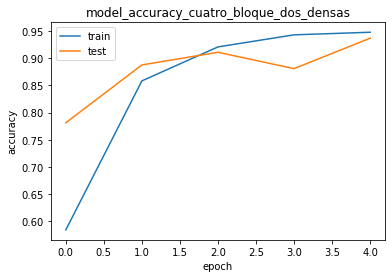

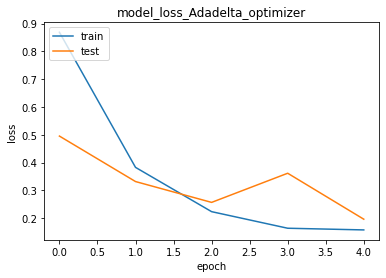

In [60]:
# Graficos

plt.plot(history_4.history['categorical_accuracy'])
plt.plot(history_4.history['val_categorical_accuracy'])
plt.title('model_accuracy_cuatro_bloque_dos_densas')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('model_loss_Adadelta_optimizer')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [61]:
# Red con cinco bloque y dos densas.

model_5 = Sequential()
model_5.add(Input(shape=(256, 256, 3)))
model_5.add(Conv2D(filters=128, kernel_size=(4, 4), activation='relu', padding='same'))
model_5.add(Conv2D(filters=128, kernel_size=(4, 4), activation='relu', padding='same'))
model_5.add(MaxPooling2D(pool_size=(4,4), strides=4, padding='same'))
model_5.add(Conv2D(filters=64, kernel_size=(4, 4), activation='relu', padding='same'))
model_5.add(Conv2D(filters=64, kernel_size=(4, 4), activation='relu', padding='same'))
model_5.add(MaxPooling2D(pool_size=(4,4), strides=4, padding='same'))
model_5.add(Conv2D(filters=32, kernel_size=(4, 4), activation='relu', padding='same'))
model_5.add(Conv2D(filters=32, kernel_size=(4, 4), activation='relu', padding='same'))
model_5.add(MaxPooling2D(pool_size=(4,4), strides=4, padding='same'))
model_5.add(Conv2D(filters=16, kernel_size=(4, 4), activation='relu', padding='same'))
model_5.add(Conv2D(filters=16, kernel_size=(4, 4), activation='relu', padding='same'))
model_5.add(MaxPooling2D(pool_size=(4,4), strides=4, padding='same'))
model_5.add(Conv2D(filters=8, kernel_size=(4, 4), activation='relu', padding='same'))
model_5.add(Conv2D(filters=8, kernel_size=(4, 4), activation='relu', padding='same'))
model_5.add(MaxPooling2D(pool_size=(1,1), strides=1, padding='valid'))
model_5.add(Flatten())
model_5.add(Dense(32, activation='relu'))
model_5.add(Dense(4, activation='softmax'))

In [62]:
model_5.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_68 (Conv2D)          (None, 256, 256, 128)     6272      
                                                                 
 conv2d_69 (Conv2D)          (None, 256, 256, 128)     262272    
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 64, 64, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 64, 64, 64)        131136    
                                                                 
 conv2d_71 (Conv2D)          (None, 64, 64, 64)        65600     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                

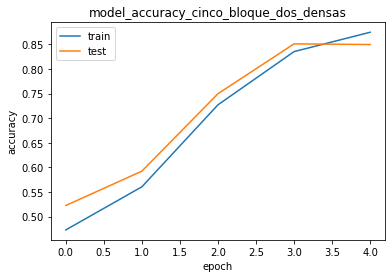

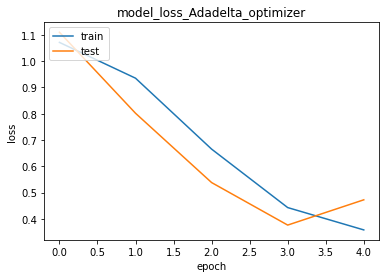

In [64]:
# Graficos

plt.plot(history_5.history['categorical_accuracy'])
plt.plot(history_5.history['val_categorical_accuracy'])
plt.title('model_accuracy_cinco_bloque_dos_densas')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history_5.history['loss'])
plt.plot(history_5.history['val_loss'])
plt.title('model_loss_Adadelta_optimizer')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [63]:
# Graficos y scores del modelo_5

model_5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy']) 

# Fit the model

history_5 = model_5.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=10)

Epoch 1/5
293/293 [==============================] - 1606s 5s/step - loss: 1.0712 - categorical_accuracy: 0.4730 - val_loss: 1.1098 - val_categorical_accuracy: 0.5226
Epoch 2/5
293/293 [==============================] - 1596s 5s/step - loss: 0.9351 - categorical_accuracy: 0.5605 - val_loss: 0.8017 - val_categorical_accuracy: 0.5923
Epoch 3/5
293/293 [==============================] - 1605s 5s/step - loss: 0.6652 - categorical_accuracy: 0.7271 - val_loss: 0.5379 - val_categorical_accuracy: 0.7497
Epoch 4/5
293/293 [==============================] - 1599s 5s/step - loss: 0.4428 - categorical_accuracy: 0.8352 - val_loss: 0.3761 - val_categorical_accuracy: 0.8509
Epoch 5/5
293/293 [==============================] - 1590s 5s/step - loss: 0.3578 - categorical_accuracy: 0.8745 - val_loss: 0.4723 - val_categorical_accuracy: 0.8495


## 1.f Data Augmentation

Otra manera de evitar sobreajuste y mejorar los desempeños de una red convolucional es usar aumentación de datos. La idea detrás de este método es un hecho muy simple: si rotamos ligeramente una foto por ejemplo de un caballo, seguirá siendo de un caballo. Lo mismo si la movemos ligeramente hacia algun lado, hacia arriba, etc.

Keras trae implementado un generador de imágenes aumentadas como se muestra en el *código* a continuación. Explore a lo menos 4 variaciones del generador a continuación, la elección de los parámetros y sus respectivos valores queda en sus manos). Una vez generada la data aumentada, entrene la mejor red que haya obtenido a lo largo de toda la tarea.

Pregunta: ¿Mejora el desempeño de la red utilizando aumentación de datos?

* Es claro que el desempeño de la red mejora con aumentación de datos siempre y cuando tengan sentido las transformaciones utilizadas, hay casos en que rotaciones demasiado grandes o demasiado contraste puede resultar contraproducente por que hay que tener esas salvedades

In [65]:
def newmodel():
    model = Sequential()
    model.add(Input(shape=(256, 256, 3)))
    model.add(Conv2D(filters=128, kernel_size=(4, 4), activation='relu', padding='same'))
    model.add(Conv2D(filters=128, kernel_size=(4, 4), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(4,4), strides=4, padding='same'))
    model.add(Conv2D(filters=64, kernel_size=(4, 4), activation='relu', padding='same'))
    model.add(Conv2D(filters=64, kernel_size=(4, 4), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(4,4), strides=4, padding='same'))
    model.add(Conv2D(filters=32, kernel_size=(4, 4), activation='relu', padding='same'))
    model.add(Conv2D(filters=32, kernel_size=(4, 4), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(4,4), strides=4, padding='same'))
    model.add(Conv2D(filters=16, kernel_size=(4, 4), activation='relu', padding='same'))
    model.add(Conv2D(filters=16, kernel_size=(4, 4), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(4,4), strides=4, padding='valid'))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    return model

In [67]:
datagen = ImageDataGenerator(
        featurewise_center = False,  # set input mean to 0 over the dataset
        samplewise_center = False,  # set each sample mean to 0
        featurewise_std_normalization = False,  # divide inputs by std of the dataset
        samplewise_std_normalization = False,  # divide each input by its std
        zca_whitening = False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = .1, # Randomly zoom image 
        width_shift_range= .1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range= .1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip= True,  # randomly flip images
        vertical_flip= False)  # randomly flip images

model = newmodel()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy']) 

In [70]:
model.fit(datagen.flow(X_train, y_train, batch_size=32), 
          validation_data=(X_val, y_val), 
          steps_per_epoch=len(X_train) // 32, 
          epochs=5)


Epoch 1/5
91/91 [==============================] - 1559s 17s/step - loss: 1.1974 - categorical_accuracy: 0.3717 - val_loss: 0.9201 - val_categorical_accuracy: 0.5595
Epoch 2/5
91/91 [==============================] - 1544s 17s/step - loss: 0.8852 - categorical_accuracy: 0.5664 - val_loss: 0.9004 - val_categorical_accuracy: 0.6293
Epoch 3/5
91/91 [==============================] - 1541s 17s/step - loss: 0.5779 - categorical_accuracy: 0.7714 - val_loss: 0.5493 - val_categorical_accuracy: 0.7921
Epoch 4/5
91/91 [==============================] - 1543s 17s/step - loss: 0.3914 - categorical_accuracy: 0.8555 - val_loss: 0.3179 - val_categorical_accuracy: 0.8960
Epoch 5/5
91/91 [==============================] - 1545s 17s/step - loss: 0.3105 - categorical_accuracy: 0.8942 - val_loss: 0.2767 - val_categorical_accuracy: 0.9124


In [71]:
datagen = ImageDataGenerator(
        featurewise_center = True,  # set input mean to 0 over the dataset
        samplewise_center = True,  # set each sample mean to 0
        featurewise_std_normalization = False,  # divide inputs by std of the dataset
        samplewise_std_normalization = False,  # divide each input by its std
        zca_whitening = False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = .2, # Randomly zoom image 
        width_shift_range= .2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range= .2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip= True,  # randomly flip images
        vertical_flip= False)  # randomly flip images

model = newmodel()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy']) 

In [72]:
model.fit(datagen.flow(X_train, y_train, batch_size=32), 
          validation_data=(X_val, y_val), 
          steps_per_epoch=len(X_train) // 32, 
          epochs=5)


C:\Users\carlo\miniconda3\envs\IAold\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
91/91 [==============================] - 1553s 17s/step - loss: 1.0309 - categorical_accuracy: 0.4796 - val_loss: 1.0076 - val_categorical_accuracy: 0.5828
Epoch 2/5
91/91 [==============================] - 1543s 17s/step - loss: 0.6625 - categorical_accuracy: 0.7165 - val_loss: 0.5150 - val_categorical_accuracy: 0.8454
Epoch 3/5
91/91 [==============================] - 1545s 17s/step - loss: 0.4225 - categorical_accuracy: 0.8430 - val_loss: 0.7729 - val_categorical_accuracy: 0.7975
Epoch 4/5
91/91 [==============================] - 1541s 17s/step - loss: 0.3409 - categorical_accuracy: 0.8772 - val_loss: 0.2691 - val_categorical_accuracy: 0.9056
Epoch 5/5
91/91 [==============================] - 1543s 17s/step - loss: 0.2465 - categorical_accuracy: 0.9125 - val_loss: 0.3314 - val_categorical_accuracy: 0.9042


In [73]:
datagen = ImageDataGenerator(
        featurewise_center = True,  # set input mean to 0 over the dataset
        samplewise_center = True,  # set each sample mean to 0
        featurewise_std_normalization = False,  # divide inputs by std of the dataset
        samplewise_std_normalization = False,  # divide each input by its std
        zca_whitening = True,  # apply ZCA whitening
        brightness_range = (-.1,.1),
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = .2, # Randomly zoom image 
        width_shift_range= .2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range= .2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip= True,  # randomly flip images
        vertical_flip= False)  # randomly flip images

model = newmodel()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy']) 

In [74]:
model.fit(datagen.flow(X_train, y_train, batch_size=32), 
          validation_data=(X_val, y_val), 
          steps_per_epoch=len(X_train) // 32, 
          epochs=5)


C:\Users\carlo\miniconda3\envs\IAold\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\carlo\miniconda3\envs\IAold\lib\site-packages\keras_preprocessing\image\image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
91/91 [==============================] - 1547s 17s/step - loss: 1.3248 - categorical_accuracy: 0.3610 - val_loss: 1.1965 - val_categorical_accuracy: 0.5157
Epoch 2/5
91/91 [==============================] - 1546s 17s/step - loss: 1.2023 - categorical_accuracy: 0.4343 - val_loss: 1.0351 - val_categorical_accuracy: 0.5376
Epoch 3/5
91/91 [==============================] - 1552s 17s/step - loss: 1.1444 - categorical_accuracy: 0.4481 - val_loss: 1.0465 - val_categorical_accuracy: 0.5527
Epoch 4/5
91/91 [==============================] - 1551s 17s/step - loss: 1.1491 - categorical_accuracy: 0.4537 - val_loss: 0.8969 - val_categorical_accuracy: 0.5636
Epoch 5/5
91/91 [==============================] - 1563s 17s/step - loss: 1.0978 - categorical_accuracy: 0.4720 - val_loss: 0.8210 - val_categorical_accuracy: 0.5814


In [75]:
datagen = ImageDataGenerator(
        featurewise_center = True,  # set input mean to 0 over the dataset
        samplewise_center = True,  # set each sample mean to 0
        featurewise_std_normalization = True,  # divide inputs by std of the dataset
        samplewise_std_normalization = True,  # divide each input by its std
        zca_whitening = True,  # apply ZCA whitening
        shear_range = .1
        brightness_range = (-.1,.1),
        rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = .3, # Randomly zoom image 
        width_shift_range= .2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range= .2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip= True,  # randomly flip images
        vertical_flip= True)  # randomly flip images

model = newmodel()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy']) 

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3129675714.py, line 7)

In [ ]:
model.fit(datagen.flow(X_train, y_train, batch_size=32), 
          validation_data=(X_val, y_val), 
          steps_per_epoch=len(X_train) // 32, 
          epochs=5)


## 1.g Bloque Residual

A continuación se probaran arquitecturas de red con conexiones residuales, puede usar la data aumentada si le parece indicado.

<center><img src="https://production-media.paperswithcode.com/methods/resnet-e1548261477164.png" width="300"/></center>


En la imagen se muestra el bloque básico de la arquitectura de la primera variación de la Red Residual: ResNet (https://arxiv.org/abs/1512.03385). Investigue las principales motivaciones de cómo implementar este tipo de red, sus ventajas, sus desventajas y luego cree y entrene una red con 1, 2, 3, 4 y 5 bloques residuales. ¿Como deben ser las dimensiones del input $x$ y de $\mathcal{F}(x)$ para poder realizar la operación $\mathcal{F}(x) + x$ entes del *relu* de más abajo?, ¿qué tipo de padding hay que usar en la convolución para mantener las mismas dimensiones de entrada y de salida?

## 1.h Bloque Inception

En preguntas anteriores se pidió probar con distintos tamaños de kernel, en este tipo de bloque la idea es usar varios tamaños al mismo tiempo y así extraer características de contextos grandes y pequeños.

Para comenzar es útil preguntarse: ¿Qué pasa si se desea modificar solamente el número de canales?. Existe una forma de mantener las dimensiones de entrada, modificando el número de canales de la salida: La convolución $1 \times 1$.

Imagine que tiene una matriz $M$ de tamaño $6 \times 6$, si realiza una convolución con una matriz $m$ de $1\times 1$ y luego una activación, entonces $M^{6 \times 6} * m^{1\times 1}$ será una multiplicación element-wise entre el valor de $m$ y cada elemento de $M$ resultando luego de la activación otra matriz de $6\times 6$. 

Teniendo en mente lo anterior, suponga ahora que la entrada es un arreglo de tamaño $(6 \times 6 \times 32)$, es decir, tiene 32 canales. Considere que desea aplicar una convolución con $N$ filtros a todos los canales, entonces el tamaño de los filtros debe ser $(1\times 1 \times 32)$, el resultado de la convolución será tendrá un tamaño $(6 \times 6 \times N)$. Por lo tanto es posible aumentar, mantener o disminuir el la cantidad de canales de la salida. La idea de mantener los canales es aplicar una activación no lineal, lo que permite a la red aprender funciónes más complejas.

Otra ventaja de la convolución $(1\times 1)$ es que ayuda a reducir 
el costo computacional entre otras convoluciones, por ejemplo si se aplican 32 filtros de tamaño $(5\times 5 \times 192)$ con padding `same` a una entrada de tamaño $(28 \times 28 \times 192)$, entonces la salida será de tamaño $(28 \times 28 \times 32)$ y el total de multiplicaciones será: $28\times 28 \times 32 \times 5 \times 5 \times 192 = 120\; \text{Millones}$. Por esta razón al aplicar convoluciones con filtros de distintos tamaños conviene reducir el número de operaciones a través de la siguiente idea llamada "cuello de botella":

- A la entrada de $(28 \times 28 \times 192)$ aplique 16 filtros convolucionales de $(1 \times 1 \times 192)$, obteniendo una salida de $(28 \times 28 \times 16)$.

- Luego aplique 32 filtros convolucionales de $(5 \times 5 \times 16)$, obteniendo una salida de $(28 \times 28 \times 32)$.

Para la primera operación se requieren $28 \times 28 \times 16 \times 192 = 2.4\; \text{Millones}$ de multiplicaciones, mientras que en la segunda son $28 \times 28 \times 32 \times 5 \times 5 \times 16 = 10\; \text{Millones}$. Finalmente sumando ambas cantidades se obtiene un total de $12.4\; \text{Millones}$ de multiplicaciones, casi un 10% de lo que se obtiene al realizar la operación directamente!.

Con todo lo anterior en mente se le pide que implemente una red con una red utilizando el bloque presentado en la imagen de abajo. Pruebe con 1,3 y 4 bloques antes de aplicar las capas densas. Note que en la imagen la entrada y la salida conservan la dimensión de $(28 \times 28)$, por lo tanto entre cada bloque *inception* puede ir bajando dicha dimensión, para obtener más información sobre la construcción del bloque puede leer el siguiente documento https://arxiv.org/pdf/1409.4842.pdf.


<center><img src="https://blog.kakaocdn.net/dn/dvyzrN/btqNkQRUokj/DrrKv0t5QJ9CyRI45aosd1/img.jpg" width="300"/><center/>

## 1.i Transfer Learning

A continuación se le pide escoger 1 modelo pre entrenado de entre los presentes en la siguiente lista https://keras.io/api/applications/, puede usar alguno de los vistos a lo largo de la tarea o puede escoger otro que le parezca. En el link anterior y en el siguiente puede encontrar información acerca de los modelos, su implementación y otras consideraciones.

Preguntas: ¿Qué es Transfer Learning?, ¿Cómo se implementa Transfer Learning con un modelo pre entrenado? (explique brevemente)

* Utilizar la capacidad de aprendizaje que tienen redes muy complejas y que han sido entrenedas con bases de datos gigantes, de manera que en problemas con pocos datos se puedan tener buenos resultados. Consiste en tomar la parte de procesamiento y convoluciones de una red compleja y agregar salidas customizadas para el caso de trabajo.

In [27]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(4, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

    
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


In [28]:
# train the model on the new data for a few epochs
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=10)

Epoch 1/10
293/293 [==============================] - 142s 472ms/step - loss: 0.8536 - accuracy: 0.7575 - val_loss: 0.2993 - val_accuracy: 0.8700
Epoch 2/10
293/293 [==============================] - 139s 474ms/step - loss: 0.3009 - accuracy: 0.8854 - val_loss: 0.2342 - val_accuracy: 0.9097
Epoch 3/10
293/293 [==============================] - 138s 471ms/step - loss: 0.2336 - accuracy: 0.9063 - val_loss: 0.2685 - val_accuracy: 0.9083
Epoch 4/10
293/293 [==============================] - 138s 473ms/step - loss: 0.2055 - accuracy: 0.9241 - val_loss: 0.1836 - val_accuracy: 0.9234
Epoch 5/10
293/293 [==============================] - 139s 476ms/step - loss: 0.1630 - accuracy: 0.9371 - val_loss: 0.1924 - val_accuracy: 0.9193
Epoch 6/10
293/293 [==============================] - 139s 473ms/step - loss: 0.1476 - accuracy: 0.9412 - val_loss: 0.2138 - val_accuracy: 0.9152
Epoch 7/10
293/293 [==============================] - 139s 475ms/step - loss: 0.1330 - accuracy: 0.9490 - val_loss: 0.1891 -

In [ ]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy')

In [30]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=10)


Epoch 1/10
293/293 [==============================] - 178s 595ms/step - loss: 0.4217 - val_loss: 0.1626
Epoch 2/10
293/293 [==============================] - 174s 594ms/step - loss: 0.1444 - val_loss: 0.1685
Epoch 3/10
293/293 [==============================] - 174s 595ms/step - loss: 0.0766 - val_loss: 0.1643
Epoch 4/10
293/293 [==============================] - 173s 592ms/step - loss: 0.0597 - val_loss: 0.1663
Epoch 5/10
293/293 [==============================] - 174s 593ms/step - loss: 0.0478 - val_loss: 0.1545
Epoch 6/10
293/293 [==============================] - 173s 592ms/step - loss: 0.0284 - val_loss: 0.1399
Epoch 7/10
293/293 [==============================] - 174s 593ms/step - loss: 0.0308 - val_loss: 0.1517
Epoch 8/10
293/293 [==============================] - 173s 592ms/step - loss: 0.0442 - val_loss: 0.1404
Epoch 9/10
293/293 [==============================] - 173s 592ms/step - loss: 0.0208 - val_loss: 0.1348
Epoch 10/10
293/293 [==============================] - 174s 594m